# Exploratory Data Analysis

We will explore our data to observe which variables are the ones that seem most likely to predict the outcome of a match.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

### User defined
import variables_n_functions as var

%load_ext autoreload
%autoreload 2

Read the file that contains the API key:

In [2]:
import yaml
key_file = open('sportmonks_token.yaml', 'r')
sports_key = yaml.safe_load(key_file)['sports_token']

We have previously retrieved a df through API calls and stored it in a csv to not make the calls again for the purpose of this exploratory data analysis.

In [43]:
df = pd.read_csv('premiership_teams_head2head.csv', index_col=0)

Note however that any column that contains dictionaries have been turned to strings

In [44]:
df['formations'].iloc[0]

"{'localteam_formation': '4-3-3', 'visitorteam_formation': '4-3-3'}"

So we turn each of these columns back to a dictionary

In [45]:
cols_to_dict = ['scores', 'time', 'coaches', 'standings',
                'assistants', 'formations', 'weather_report']

for col in cols_to_dict:
    df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else None )

We can broadly separate the variables into 3 categories:

    1. id variables : Identificators for concepts such as league, season, venue, etc.
    2. dictionary variables : Variables that themselves contain dictionaries, such as scores, formations, etc.
    3. other variables : The rest of the variables, like commentaries, attendance.
    
We will go into detail on each of these in the following notebook.

## id variables

There are many columns which are only ids for several things, such as the current season, league, stage, etc. In some cases, the ids might be useful whilst in others maybe not that much.

In [79]:
id_cols = [ col for col in list(df.columns) if 'id' in col]
df[id_cols].head()

,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,visitorteam_id,winner_team_id
0,18137008,501,18369,77453684,247452.0,NaN,NaN,8909,14853.0,53,62,53.0
0,18136904,501,18369,77453684,247434.0,NaN,NaN,8914,18748.0,62,53,62.0
0,17947857,501,17141,77447500,240676.0,243965.0,NaN,8914,14468.0,62,53,62.0
0,16475470,501,17141,77447501,194999.0,NaN,NaN,8909,14859.0,53,62,NaN
0,16475413,501,17141,77447501,194989.0,NaN,NaN,8914,14853.0,62,53,62.0


### id
The _id_ id simply the index for the unique combination of league, season, stage, etc. i.e. for the given match between the respective 2 teams. We will **not** use it for predictions since it changes for every match, but it is key to avoid duplicates when we update the database.

### league_id
The _league_id_ is the league in which the match took place (f.e. Champions League, Copa America). We consider that they **will** be useful to predict the outcome, since each league has it's own set of rules, and also they might affect the players differently.

### season_id
The _season_id_ is the season in which the match took place (f.e. 2019-2020, 2021). We will **not**  use them to predict the outcome of the match, since we can have date information from other variables.

### stage_id

_stage_id_ is the current stage for the given league and season. Thus, as it is, it is not really useful because there will be too few observations of it. What is useful is to query an API request with the _stage_id_ to obtain the _name_ and the _type_, as can be seen in the following cell:

In [89]:
r = requests.get(f'https://soccer.sportmonks.com/api/v2.0/stages/77453684?api_token={sports_key}')
eval(r.text.replace('true', 'True').replace('false', 'False'))['data']

{'id': 77453684,
 'name': '1st Phase',
 'type': 'Group Stage',
 'league_id': 501,
 'season_id': 18369,
 'sort_order': -1,
 'has_standings': True,
 'has_outgroup_matches': 0}

We will currently not retrieve these values, but we will take them into consideration in later iterations.

### round_id

The _round_id_ is the round for the given league and season; in spanish it is also known as "jornada". Thus, as it is, it is not really useful because there will be too few observations of it. What could be useful is to query an API request with the _round_id_ to obtain the _name_ (the number of the round) as can be seen in the following cell:

In [94]:
# r = requests.get(f'https://soccer.sportmonks.com/api/v2.0/rounds/247452?api_token={sports_key}')
r = requests.get(f'https://soccer.sportmonks.com/api/v2.0/rounds/240676?api_token={sports_key}')
eval(r.text.replace('true', 'True').replace('false', 'False'))['data']

{'id': 240676,
 'name': 3,
 'league_id': 501,
 'season_id': 17141,
 'stage_id': 77447500,
 'start': '2021-05-01',
 'end': '2021-05-02'}

But even then, we consider that the number of the round is not that useful to predict the outcome, so we will not get it.

### group_id

The _group_id_ is not as straightforward as the previous ones. What the API refers to as _group_id_ is when certain leagues separates the best teams from the worst after a certain amount of matches have been played. Since there are many NaN values (88.26% just in this dataset), we do not consider it to be useful to make predictions, so we will omit it.

In [110]:
str(round(100*sum(df['group_id'].isna())/len(df), 2))+'%'

'88.26%'

### aggregate_id

The _aggregate_id_ refers to when both teams play one-home and one-away games (in spanish, "ida y vuelta"). Most of the matches do not have this modality (99.62% in this dataset), thus incurring in many NaN values, so we will omit it.

In [111]:
str(round(100*sum(df['aggregate_id'].isna())/len(df), 2))+'%'

'99.62%'

### venue_id

The _venue_id_ is the id of the stadium. At first, it might seem to be repetitive considering that most of the time, the venue is the one associated to the local team. Yet, there are occassions in which certain matches are played in a venue that neither of the teams owned. We consider that this variable might be able to tell us something about the outcome of the match.

Note: We could search for each stadium's _capacity_, and use it to get the proportion up to which it was filled on a given match (by using the variable _attendance_ that we have in the dataset). This variable could be useful for our predictions, but we will explore it in later iterations.

In [117]:
r = requests.get(f'https://soccer.sportmonks.com/api/v2.0/venues/8909?api_token={sports_key}')
eval(r.text.replace('true', 'True').replace('false', 'False'))['data']

{'id': 8909,
 'name': 'Celtic Park',
 'surface': 'grass',
 'address': '18 Kerrydale Street',
 'city': 'Glasgow',
 'capacity': 60411,
 'image_path': 'https:\\/\\/cdn.sportmonks.com\\/images\\/soccer\\/venues\\/13\\/8909.png',
 'coordinates': '55.849711,-4.205589'}

### referee_id

The _referee_id_ is the id of the main/first referee. We believe that certain behaviours and actions taken by the referee could be biased, so this variable might give us some insight into the outcome of the match.

### localteam_id & visitorteam_id
These are  very straightforward, and we will definitely use them to let the model understand the historical importance of both teams winning odds against each other.

### winner_team_id
These variable equals _localteam_id_ when the local team wins, it equals _visitorteam_id_ when the visitor team wins, and is NaN in the case of a tie. This variable is considerably important, since we can extrapolate our response variable _y_ from it. We will define it as follows:

```Python
if _winner_team_id_ == _localteam_id_:
    y = 1 
elif _winner_team_id_ == _visitorteam_id_:
    y = 0
else:
    y = 0.5 
```

In [130]:
y = df.copy()
y['y'] = None
for _ in range(len(y)):
    if y['winner_team_id'].iloc[_] == y['localteam_id'].iloc[_]:
        y['y'].iloc[_] = 1 
    elif y['winner_team_id'].iloc[_] == y['visitorteam_id'].iloc[_]:
        y['y'].iloc[_] = 0 
    else:
        y['y'].iloc[_] = 0.5 

c:\users\mike\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## other variables

We will explore _other variables_ before _dictionary variables_ since the latter require particular attention for each case.

In [146]:
dict_cols = ['weather_report', 'formations', 'scores', 'time', 'coaches', 'standings', 'assistants', 'colors']
df.drop(id_cols + dict_cols, 1).head()

,commentaries,attendance,pitch,details,neutral_venue,winning_odds_calculated,leg,deleted,is_placeholder
0,True,NaN,NaN,NaN,False,True,1/1,False,False
0,True,NaN,NaN,NaN,False,True,1/1,False,False
0,True,NaN,NaN,NaN,False,True,1/1,False,False
0,False,NaN,NaN,NaN,False,True,1/1,False,False
0,False,NaN,NaN,NaN,False,True,1/1,False,False


### commentaries

The _commentaries_ column indicates whether there are registered commentaries for the match (True) or not (False). We believe that this does not affect the outcome of the match since players themselves aren't affected by a person talking over the development of a match. It could maybe be an indicator of whether the match was important enough so as to be commentated, thus incurring in some psychological effect to the players, but we will drop it for the moment.

### attendance

The _attendance_ column indicates the number of people that went to the venue to watch the match. Whilst this variable seems to give us insight into the importance of the match and to the psychological effects this might take into the players' mindset, it unfourtunately has too many missing values (92.57%). This might be due to certain mathces not allowing the entrance to people, or even just that there was no register of the total amount. Thus, we will unfortunately leave it out. Perhaps when we explore other teams the NaN percentage might drop, so we will take it into consideration when we expand our dataset.

In [155]:
str(round(100*sum(df['attendance'].isna())/len(df), 2))+'%'

'92.57%'

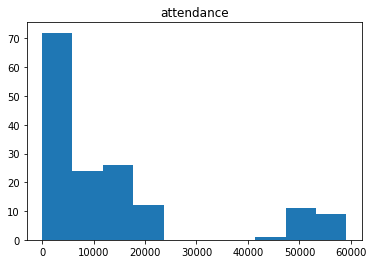

In [164]:
plt.hist(df['attendance'])
plt.title('attendance');

### pitch

The _picth_ column indicates the overall weather conditions. However has too many NaN (88.69%). We do believe that this variable can help us predict the outcome, so we will replace the NaN values with 'Regular'.

In [172]:
df[~df['pitch'].isna()]['pitch'].unique().tolist()

['Good',
 'Excellent',
 'Wet and Fast',
 'Uneven and|cutting up',
 'Artificial Turf',
 'Wet']

In [154]:
str(round(100*sum(df['pitch'].isna())/len(df), 2))+'%'

'88.69%'

### details

The _details_ column is a complete NaN. Maybe for other teams and matches this could have some values, but we will drop it until we examine if it could be useful for other cases. 

In [152]:
str(round(100*sum(df['details'].isna())/len(df), 2))+'%'

'100.0%'

### neutral_venue

The _neutral_venue_ column indicates whether the stadium did not belong to either team (True) or yes (False). At least in the case of this dataset, we only have False values (0 values), but this does not indicate that it will always be that way. For the moment, we will drop it.

In [157]:
sum(df['neutral_venue'])

0

### winning_odds_calculated

This reflects whether the odds for the outcome were calculated. We believe this does not affect in any way to the outcome of the match, so we will omit it.

### leg
The _leg_ refers to the current game number with respect to the total amount of games that the match has. For example, if America and Pumas were to compete 2 times in the tourney to advance to the next round, and the current game is the first of the 2 games, then ``leg = 1/2``. We do consider this variable can affect the outcome of the match.

In [173]:
df['leg'].unique().tolist()

['1/1', '2/2', '1/2']

### deleted

This is a metadata variable that keeps track of wether this register was deleted from the current Sportmonks DB. Thus, we will delete it.

### is_placeholder

Sportmonks documentation for this variable states: "This property indicates if the resource is used to display dummy data. The false of this property will always be a boolean value." We did not quite understand what it means, but it does not seem to affect the outcome of the match, so we drop it.

## dictionary variables

The following variables contain dictionary values in each register. They have to be analyzed individually.

In [180]:
df[dict_cols].head()

,weather_report,formations,scores,time,coaches,standings,assistants,colors
0,"{'code': 'clouds', 'type': 'broken clouds', 'i...","{'localteam_formation': '4-3-3', 'visitorteam_...","{'localteam_score': 3, 'visitorteam_score': 0,...","{'status': 'FT', 'starting_at': {'date_time': ...","{'localteam_coach_id': 896805, 'visitorteam_co...","{'localteam_position': 2, 'visitorteam_positio...","{'first_assistant_id': 12118, 'second_assistan...","{'localteam': {'color': '#339063', 'kit_colors..."
0,"{'code': 'clouds', 'type': 'overcast clouds', ...","{'localteam_formation': '4-3-3', 'visitorteam_...","{'localteam_score': 1, 'visitorteam_score': 0,...","{'status': 'FT', 'starting_at': {'date_time': ...","{'localteam_coach_id': 50, 'visitorteam_coach_...","{'localteam_position': 6, 'visitorteam_positio...","{'first_assistant_id': 12118, 'second_assistan...","{'localteam': {'color': '#2B72DE', 'kit_colors..."
0,"{'code': 'clouds', 'type': 'scattered clouds',...","{'localteam_formation': '4-3-1-2', 'visitortea...","{'localteam_score': 4, 'visitorteam_score': 1,...","{'status': 'FT', 'starting_at': {'date_time': ...","{'localteam_coach_id': 50, 'visitorteam_coach_...","{'localteam_position': 1, 'visitorteam_positio...","{'first_assistant_id': 12770, 'second_assistan...","{'localteam': {'color': '#2B72DE', 'kit_colors..."
0,"{'code': 'clouds', 'type': 'broken clouds', 'i...","{'localteam_formation': '4-2-3-1', 'visitortea...","{'localteam_score': 1, 'visitorteam_score': 1,...","{'status': 'FT', 'starting_at': {'date_time': ...","{'localteam_coach_id': 2163, 'visitorteam_coac...","{'localteam_position': 2, 'visitorteam_positio...","{'first_assistant_id': 14860, 'second_assistan...","{'localteam': {'color': '#F0F0F0', 'kit_colors..."
0,"{'code': 'clear', 'type': 'clear sky', 'icon':...","{'localteam_formation': '4-3-3', 'visitorteam_...","{'localteam_score': 1, 'visitorteam_score': 0,...","{'status': 'FT', 'starting_at': {'date_time': ...","{'localteam_coach_id': 50, 'visitorteam_coach_...","{'localteam_position': 1, 'visitorteam_positio...","{'first_assistant_id': 12118, 'second_assistan...","{'localteam': {'color': '#2B72DE', 'kit_colors..."


### weather_report

This variable contains several values regarding the weather conditions, such as whether it was clear, sunny, cloudy, etc, the precipitaion, humidity, and more. We do believe it is a good variable to predict the outcome, but unfortunately it has 65.29% missing values for our dataset. We will take it into consideration when we use other teams and leagues if in such cases it has a way lower proportion of NaN values.

In [193]:
df['weather_report'].iloc[0]

{'code': 'clouds',
 'type': 'broken clouds',
 'icon': 'https://cdn.sportmonks.com/images/weather/04n.png',
 'temperature': {'temp': 48.09, 'unit': 'fahrenheit'},
 'temperature_celcius': {'temp': 8.9, 'unit': 'celcius'},
 'clouds': '75%',
 'humidity': '93%',
 'pressure': 1015,
 'wind': {'speed': '14.97 m/s', 'degree': 230},
 'coordinates': {'lat': 55.8652, 'lon': -4.2576},
 'updated_at': '2022-02-02T21:30:03.652856Z'}

In [209]:
str(round(100*sum(df['weather_report'].isna())/len(df), 2))+'%'

'65.29%'

### formations

These contain the local and the visitor team formations. Most of this will be 4-3-3, but in certain occasions there might be variations, so we believe this variable could be of use.

In [191]:
df['formations'].iloc[0]

{'localteam_formation': '4-3-3', 'visitorteam_formation': '4-3-3'}

### scores

These contain information on the amount of goals that were scored by both teams. This is a variable that is only known after the match has ended, so we cannot use it to predict the outcome. However, it can be used as a predicted variable if we were to choose to model it this way.

In [182]:
df['scores'].iloc[0]

{'localteam_score': 3,
 'visitorteam_score': 0,
 'localteam_pen_score': None,
 'visitorteam_pen_score': None,
 'ht_score': '3-0',
 'ft_score': '3-0',
 'et_score': None,
 'ps_score': None}

### time

This variable contains information related to the time and date of the match. This can be useful in combination to other variables. For example, we could introduce a variable called _localteam_score_history_ in which we make a weighted sum of the goals with respect to how recently they were made:

- Chivas ::: 2022-02 ::: 60 days from today  ::: 3 goals
- Chivas ::: 2021-12 ::: 120 days from today ::: 0 goals
- Chivas ::: 2021-11 ::: 150 days from today ::: 1 goals
- Chivas ::: 2021-09 ::: 210 days from today ::: 3 goals

Let $\lambda = 0.99$, and 720 (2 years) be our maximum window, then:

$$\text{localteam_score_history} = \lambda^{60/720} \times 3 + \lambda^{120/720} \times 0 + \lambda^{150/720} \times 1 + \lambda^{210/720} \times 3$$

And the same would go for _visitorteam_score_history_

In [189]:
df['time'].iloc[0]

{'status': 'FT',
 'starting_at': {'date_time': '2022-02-02 19:45:00',
  'date': '2022-02-02',
  'time': '19:45:00',
  'timestamp': 1643831100,
  'timezone': 'UTC'},
 'minute': 95,
 'second': None,
 'added_time': None,
 'extra_minute': None,
 'injury_time': None}

### standings

These dictionaries contain values refering to the current position in the toruney table of both the local and the visitor teams. We believe this will be useful.

In [184]:
df['standings'].iloc[0]

{'localteam_position': 2, 'visitorteam_position': 1}

### colors

These dictionaries contain values refering to the colors of the teams' jerseys. We do not believe it affects a match, so we drop it.